In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
import rdkit
import os 

import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (LeaveOneOut, cross_val_predict,
                                     cross_val_score, train_test_split)

import numpy as np 

from rdkit.Chem import Descriptors
#print(len(Descriptors._descList))
#print(Descriptors._descList[:5])
#print(rdkit.__version__)

from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

Read molecules labels and generate standard descriptors

In [2]:
# those are the output data
moldescriptors = []
molnames = []
labels = []
molecules = []

usefingerprints = False
readchargeandmult = False

fp = open('./data/labels.txt', 'r')

for line in fp:
    sline = line.replace("\t", " ").replace("\n", "").rstrip().lstrip().split()
    molname = sline[1]

    molnames.append(molname)
    labels.append(float(sline[-1]))
    molecules.append(None)
    moldescriptors.append(None)

fp.close()

idxtorm = []
for dir in os.listdir('./data'):
    if os.path.isdir('./data/'+dir):
        if dir in molnames:
            index = molnames.index(dir)
            for file in os.listdir('./data/'+dir):
                if file.endswith('.pdb'):
                    m = None
                    with suppress_stdout_stderr():
                        m = rdkit.Chem.rdmolfiles.MolFromPDBFile('./data/'+dir+"/"+file)
    
                    if m is None:
                        print("Error reading file:", dir)
                        idxtorm.append(index)
                    else:
                        molecules[index] = m
    
# generate the fingerprints and descriptors
fingersize = 64
rdgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=fingersize)

for idx, m in enumerate(molecules):
    #np_bits = rdgen.GetFingerprintAsNumPy(m)
    res = {}

    if usefingerprints:
        np_counts = None
        if m is not None:
            np_counts = rdgen.GetCountFingerprintAsNumPy(m)

        res["Fingerprint"] = np_counts

    missingVal=None
    for nm,fn in Descriptors._descList:
        val = None
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            # redirect stdout to supress the warning messages when calling a funxtion
            # that is deprecated
            with suppress_stdout_stderr():
                val = fn(m)
        except:
            # print the error message:
            #import traceback
            #traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal

        res[nm] = val

    moldescriptors[idx] = res

if readchargeandmult:
    # need to add charge and spin to the descriptors
    for dir in os.listdir('./data'):
        if os.path.isdir('./data/'+dir):
            if dir in molnames:
                index = molnames.index(dir)
    
                if os.path.isfile("./data/"+dir+"/.CHRG") and \
                    os.path.isfile("./data/"+dir+"/.UHF"):
                
                    fp = open("./data/"+dir+"/.CHRG", "r")
                    charge = float(fp.readline().rstrip().lstrip())
                    fp.close()
                    fp = open("./data/"+dir+"/.UHF", "r")
                    spin = float(fp.readline().rstrip().lstrip())
                    fp.close()
                    moldescriptors[index]["Charge"] = charge
                    moldescriptors[index]["Spin"] = spin 
                else:
                    print("Charge, UHF, molname not found:", dir)
                    idxtorm.append(index)

for i in range(len(moldescriptors)):
    for k,v in moldescriptors[i].items():
        if v is None:
            moldescriptors[i][k] = 0.0
        elif v is np.nan:   
            moldescriptors[i][k] = 0.0 

# remove all molecules without a label
for i, val in enumerate(labels):
    if val is None:
        print("Label not presente for:", molnames[i])
        idxtorm.append(index)

for i in sorted(idxtorm, reverse=True):
    del labels[i]
    del moldescriptors[i]
    del molnames[i]
    del molecules[i]
        
print("")
print("Number of molecules:", len(molecules))
print("Number of labels:", len(labels))
print("Number of descriptors:", len(moldescriptors))
print("Number of names:", len(molnames))

Error reading file: oclo

Number of molecules: 139
Number of labels: 139
Number of descriptors: 139
Number of names: 139


Read PBE data

In [3]:
import re

pbelist = ["Nuclear Repulsion  :", \
            "One Electron Energy:", \
            "Two Electron Energy:", \
            "Potential Energy   :", \
            "Kinetic Energy     :", \
            "E(X)               :"  , \
            "E(C)               :"  , \
            "Dispersion correction", \
            "Total Charge"   , \
            "Multiplicity"   , \
            "Number of Electrons"]

pbedescriptor = {}

for file in os.listdir('./qdata/PBE/'):
    if file.endswith('.out'):
        molname = file.split('.out')[0]
        molname = re.split("\.mpi\d+", molname)[0]
        #print(molname)
        moldesc = {}
        fp = open('./qdata/PBE/'+file, 'r')
        for line in fp:
            for val in pbelist:
                if line.find(val) != -1:
                    keyval = val.replace(":", "").rstrip().lstrip().replace(" ", "_")
                    sline = line.rstrip().lstrip().split()
                    for sval in sline:
                        try:
                            firstnumvalue = float(sval)
                            break
                        except:
                            continue
                    
                    moldesc[keyval] = firstnumvalue
                    #print(molname, keyval, sval)
        fp.close()
        pbedescriptor[molname] = moldesc

for i, molname in enumerate(molnames):
    if molname in pbedescriptor:
        moldescriptors[i]["PBE_Total_Charge"] = pbedescriptor[molname]["Total_Charge"]
        moldescriptors[i]["PBE_Multiplicity"] = pbedescriptor[molname]["Multiplicity"]
        moldescriptors[i]["PBE_Number_of_Electrons"] = pbedescriptor[molname]["Number_of_Electrons"]
        moldescriptors[i]["PBE_Nuclear_Repulsion"] = pbedescriptor[molname]["Nuclear_Repulsion"]
        moldescriptors[i]["PBE_One_Electron_Energy"] = pbedescriptor[molname]["One_Electron_Energy"]
        moldescriptors[i]["PBE_Two_Electron_Energy"] = pbedescriptor[molname]["Two_Electron_Energy"]
        moldescriptors[i]["PBE_Potential_Energy"] = pbedescriptor[molname]["Potential_Energy"]
        moldescriptors[i]["PBE_Kinetic_Energy"] = pbedescriptor[molname]["Kinetic_Energy"]
        moldescriptors[i]["PBE_E(X)"] = pbedescriptor[molname]["E(X)"]
        moldescriptors[i]["PBE_E(C)"] = pbedescriptor[molname]["E(C)"]
        moldescriptors[i]["PBE_Dispersion_correction"] = \
            pbedescriptor[molname]["Dispersion_correction"]
    else:
        print(molname + " not found in PBE descriptors")


print("")
print("Number of molecules:", len(molecules))
print("Number of labels:", len(labels))
print("Number of descriptors:", len(moldescriptors))
print("Number of names:", len(molnames))        


Number of molecules: 139
Number of labels: 139
Number of descriptors: 139
Number of names: 139


Read HF data

In [4]:

hflist = ["Nuclear Repulsion  :", \
          "One Electron Energy:", \
          "Two Electron Energy:", \
          "Potential Energy   :", \
          "Kinetic Energy     :", \
          "Dispersion correction", \
          "Total Charge", \
          "Multiplicity", \
          "Number of Electrons"]

hfdescriptor = {}

for file in os.listdir('./qdata/PBE/'):
    if file.endswith('.out'):
        molname = file.split('.out')[0]
        molname = re.split("\.mpi\d+", molname)[0]
        #print(molname)
        moldesc = {}
        fp = open('./qdata/HF/'+file, 'r')
        for line in fp:
            for val in hflist:
                if line.find(val) != -1:
                    keyval = val.replace(":", "").rstrip().lstrip().replace(" ", "_")
                    sline = line.rstrip().lstrip().split()
                    for sval in sline:
                        try:
                            firstnumvalue = float(sval)
                            break
                        except:
                            continue
                    
                    moldesc[keyval] = firstnumvalue
                    #print(molname, keyval, sval)
        fp.close()
        hfdescriptor[molname] = moldesc

for i, molname in enumerate(molnames):
    if molname in pbedescriptor:
        moldescriptors[i]["HF_Total_Charge"] = hfdescriptor[molname]["Total_Charge"]
        moldescriptors[i]["HF_Multiplicity"] = hfdescriptor[molname]["Multiplicity"]
        moldescriptors[i]["HF_Number_of_Electrons"] = hfdescriptor[molname]["Number_of_Electrons"]
        moldescriptors[i]["HF_Nuclear_Repulsion"] = hfdescriptor[molname]["Nuclear_Repulsion"]
        moldescriptors[i]["HF_One_Electron_Energy"] = hfdescriptor[molname]["One_Electron_Energy"]
        moldescriptors[i]["HF_Two_Electron_Energy"] = hfdescriptor[molname]["Two_Electron_Energy"]
        moldescriptors[i]["HF_Potential_Energy"] = hfdescriptor[molname]["Potential_Energy"]
        moldescriptors[i]["HF_Kinetic_Energy"] = hfdescriptor[molname]["Kinetic_Energy"]
        moldescriptors[i]["HF_Dispersion_correction"] = \
            hfdescriptor[molname]["Dispersion_correction"]
    else:
        print(molname + " not found in HF descriptors")


print("")
print("Number of molecules:", len(molecules))
print("Number of labels:", len(labels))
print("Number of descriptors:", len(moldescriptors))
print("Number of names:", len(molnames))   


Number of molecules: 139
Number of labels: 139
Number of descriptors: 139
Number of names: 139


Remove molecules with some missing descriptor

In [5]:
alldims = set([len(val) for val in moldescriptors])
idxtoremovs = []
for i, val in enumerate(moldescriptors):
    if len(val) != max(alldims):
        idxtoremovs.append(i)

for i in sorted(idxtoremovs, reverse=True):
    print("Molname to remove:", molnames[i], "index:", i)
    del moldescriptors[i]
    del labels[i]
    del molnames[i]
    del molecules[i]

print("")
print("Number of molecules:", len(molecules))
print("Number of labels:", len(labels))
print("Number of descriptors:", len(moldescriptors))
print("Number of names:", len(molnames))  


Number of molecules: 139
Number of labels: 139
Number of descriptors: 139
Number of names: 139


Remove molecules with None Label 

In [6]:
for i, v in enumerate(labels):
    if v is None:
        print("None value found in labels:", i, molnames[i])
        del moldescriptors[i]
        del labels[i]
        del molnames[i]
        del molecules[i]

print("")
print("Number of molecules:", len(molecules))
print("Number of labels:", len(labels))
print("Number of descriptors:", len(moldescriptors))
print("Number of names:", len(molnames))  


Number of molecules: 139
Number of labels: 139
Number of descriptors: 139
Number of names: 139


If a descriptor is nan at least for a molecule remove from all

In [7]:
import math 

nandescriptors = set()
for index, molname in enumerate(molnames):
    if any(math.isnan(val) for val in moldescriptors[index].values()):
        print("Nan value found in descriptors:", molname)
        for k,v in moldescriptors[index].items():
            if math.isnan(v):
                nandescriptors.add(k)

print("Removing the following Descriptors ", nandescriptors)
print("Removing ", len(nandescriptors), " descriptors")
for i, v in enumerate(moldescriptors):
    for k in nandescriptors:
        del moldescriptors[i][k]


print("")
print("Number of descriptors:", len(moldescriptors[0]))
print("")
print("Number of molecules:", len(molecules))
print("Number of labels:", len(labels))
print("Number of descriptors:", len(moldescriptors))
print("Number of names:", len(molnames))  

Nan value found in descriptors: h2
Nan value found in descriptors: bef2
Nan value found in descriptors: becl2
Nan value found in descriptors: bn3pi
Nan value found in descriptors: p2
Nan value found in descriptors: bn
Nan value found in descriptors: be2
Removing the following Descriptors  {'BCUT2D_LOGPLOW', 'MinPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'MaxAbsPartialCharge', 'BCUT2D_CHGLO', 'MaxPartialCharge', 'BCUT2D_CHGHI', 'BCUT2D_LOGPHI', 'MinAbsPartialCharge', 'BCUT2D_MWLOW'}
Removing  12  descriptors

Number of descriptors: 216

Number of molecules: 139
Number of labels: 139
Number of descriptors: 139
Number of names: 139


Build features matrix

In [8]:
moldescriptors_featues = []
Y = []
features_names = []

for idx, molname in enumerate(molnames):
    val = []
    for k,v in moldescriptors[idx].items():
        if k == "Fingerprint":
            val.extend(v)
        else:   
            if idx == 0:
                features_names.append(k)
            val.append(v)
    moldescriptors_featues.append(val)
    Y.append(labels[idx])

Y = np.array(Y)
moldescriptors_featues = np.array(moldescriptors_featues)
#print(features_names)

Build model using all features

2023-11-13 10:03:44.760524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 10:03:44.800908: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


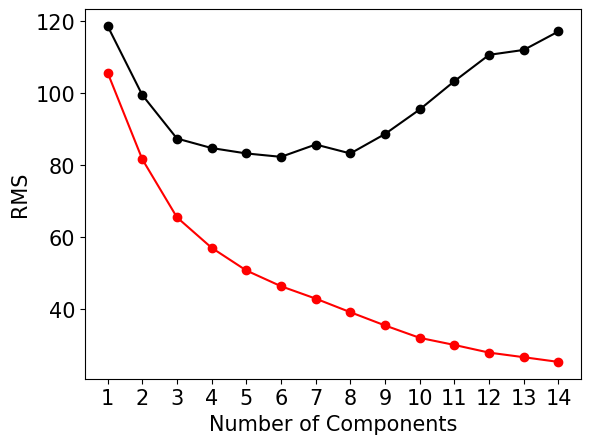

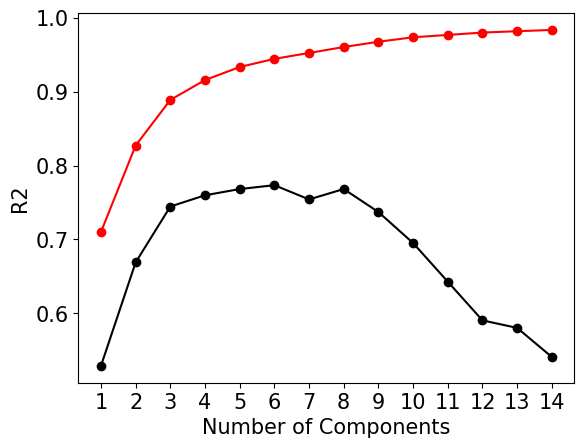

Max R2 Test set:  0.7734265100666768  N. Comps:  6
Min RMSE Test set:  82.3123680485128  N. Comps:  6


In [9]:
import models
%reload_ext models

perc_split = 0.2
ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
    models.pls_model (0.2, moldescriptors_featues, Y)

r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
print("Max R2 Test set: ", np.max(r2s_test), " N. Comps: ", r2max_comps)
print("Min RMSE Test set: ", np.min(rmses_test), " N. Comps: ", rmsemin_comps)

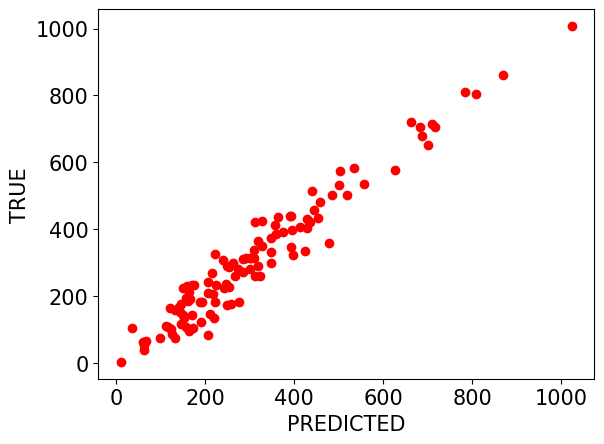

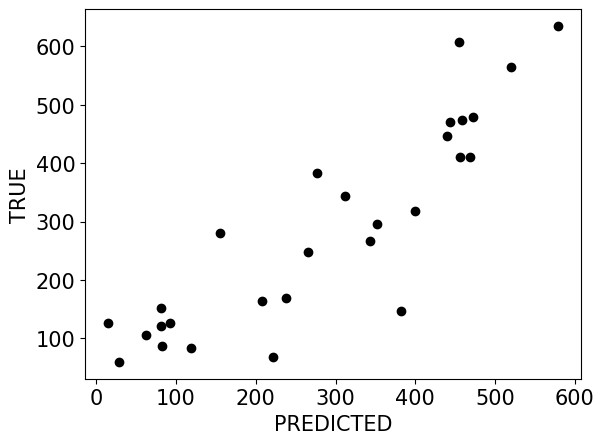

In [10]:
compstouse = min(rmsemin_comps, r2max_comps)
perc_split = 0.2
models.pls_model (0.2, moldescriptors_featues, Y, False, compstouse)

List Highly correlate variables

In [17]:
# build correlation matrix for the descriptors
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_top_correlations_blog(df, threshold=0.4):
    """
    df: the dataframe to get correlations from
    threshold: the maximum and minimum value to include for correlations. For eg, if this is 0.4, only pairs haveing a correlation coefficient greater than 0.4 or less than -0.4 will be included in the results. 
    """
    orig_corr = df.corr()
    c = orig_corr.abs()

    so = c.unstack()

    #print("|    Variable 1    |    Variable 2    | Correlation Coefficient    |")
    #print("|------------------|------------------|----------------------------|")
    
    #i=0
    pairs=set()
    result = []
    for index, value in so.sort_values(ascending=False).items():
        # Exclude duplicates and self-correlations
        if value > threshold \
        and index[0] != index[1] \
        and (index[0], index[1]) not in pairs \
        and (index[1], index[0]) not in pairs:
            
            #print(f'|    {index[0]}    |    {index[1]}    |    {orig_corr.loc[(index[0], index[1])]}    |')
            #result.loc[i, ['Variable 1', 'Variable 2', 'Correlation Coefficient']] = \
            #    [index[0], index[1], orig_corr.loc[(index[0], index[1])]]
            result.append([index[0], index[1], orig_corr.loc[(index[0], index[1])]])
            pairs.add((index[0], index[1]))
            #i+=1
            
    #return result.reset_index(drop=True).set_index(['Variable 1', 'Variable 2'])
    return result

df = pd.DataFrame(moldescriptors_featues, columns=features_names)

top_corr = get_top_correlations_blog(df, 0.8)
for tc in top_corr:
    print(tc)

['FpDensityMorgan2', 'FpDensityMorgan3', 1.0]
['MaxAbsEStateIndex', 'MaxEStateIndex', 1.0]
['PBE_Multiplicity', 'HF_Multiplicity', 1.0]
['PBE_Number_of_Electrons', 'HF_Number_of_Electrons', 1.0]
['PBE_Nuclear_Repulsion', 'HF_Nuclear_Repulsion', 1.0]
['NumAliphaticHeterocycles', 'NumAliphaticRings', 1.0]
['NumAromaticRings', 'NumAromaticHeterocycles', 1.0]
['fr_COO', 'fr_Al_COO', 1.0]
['fr_Al_OH_noTert', 'fr_Al_OH', 1.0]
['NumSaturatedRings', 'NumSaturatedHeterocycles', 1.0]
['Chi4v', 'NumAromaticRings', 0.9999999999999999]
['NumAromaticHeterocycles', 'Chi4v', 0.9999999999999999]
['NumAromaticRings', 'Chi4n', 0.9999999999999997]
['Chi4n', 'Chi4v', 0.9999999999999997]
['Chi4n', 'NumAromaticHeterocycles', 0.9999999999999997]
['HF_Potential_Energy', 'PBE_Potential_Energy', 0.9999999077738279]
['PBE_One_Electron_Energy', 'HF_One_Electron_Energy', 0.9999998976281652]
['PBE_Kinetic_Energy', 'HF_Kinetic_Energy', 0.9999997258169795]
['HF_Potential_Energy', 'HF_Kinetic_Energy', -0.99999969853408

Most of the features are highly correlated  test using only PBE or only HF

In [18]:
PBE_moldescriptors_featues = []
PBE_Y = []
PBE_features_names = []

for idx, molname in enumerate(molnames):
    val = []
    for k,v in moldescriptors[idx].items():
        if k.startswith("PBE_"):
            if idx == 0:
                PBE_features_names.append(k)
            val.append(v)
    PBE_moldescriptors_featues.append(val)
    PBE_Y.append(labels[idx])

PBE_Y = np.array(Y)
PBE_moldescriptors_featues = np.array(PBE_moldescriptors_featues)
print(PBE_features_names)
df = pd.DataFrame(PBE_moldescriptors_featues, columns=PBE_features_names)

top_corr = get_top_correlations_blog(df, 0.8)
for tc in top_corr:
    print(tc)


['PBE_Total_Charge', 'PBE_Multiplicity', 'PBE_Number_of_Electrons', 'PBE_Nuclear_Repulsion', 'PBE_One_Electron_Energy', 'PBE_Two_Electron_Energy', 'PBE_Potential_Energy', 'PBE_Kinetic_Energy', 'PBE_E(X)', 'PBE_E(C)', 'PBE_Dispersion_correction']
['PBE_Kinetic_Energy', 'PBE_Potential_Energy', -0.9999996597183057]
['PBE_One_Electron_Energy', 'PBE_Two_Electron_Energy', -0.9968807479826913]
['PBE_E(C)', 'PBE_Number_of_Electrons', -0.9960223888545602]
['PBE_E(X)', 'PBE_One_Electron_Energy', 0.9937876964674652]
['PBE_Two_Electron_Energy', 'PBE_E(X)', -0.9935417292742765]
['PBE_One_Electron_Energy', 'PBE_Potential_Energy', 0.9896731367671323]
['PBE_Kinetic_Energy', 'PBE_One_Electron_Energy', -0.9896151144335718]
['PBE_E(X)', 'PBE_Potential_Energy', 0.9785842330256068]
['PBE_E(X)', 'PBE_Kinetic_Energy', -0.9785125741607341]
['PBE_E(C)', 'PBE_E(X)', 0.976819648398598]
['PBE_Potential_Energy', 'PBE_Two_Electron_Energy', -0.9753441711065326]
['PBE_Kinetic_Energy', 'PBE_Two_Electron_Energy', 0.975

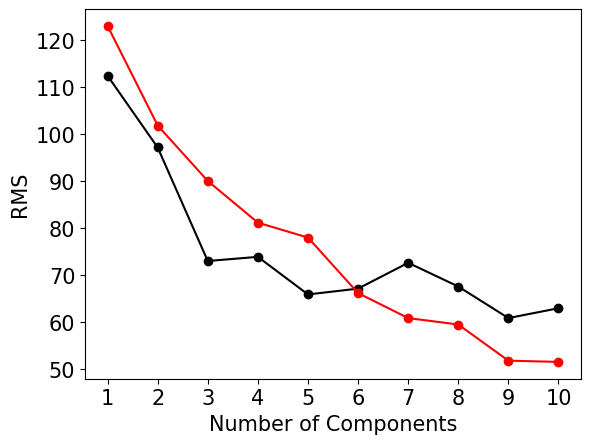

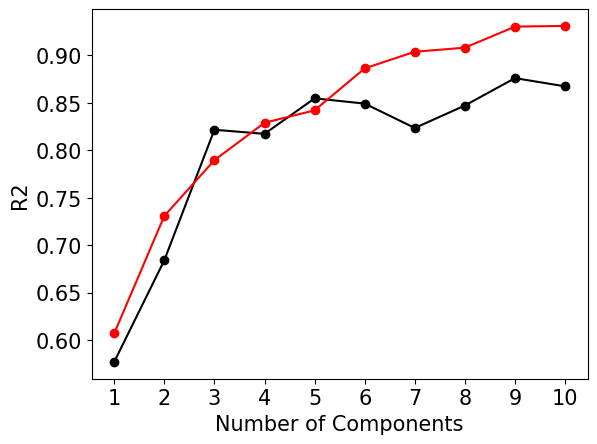

Max R2 Test set:  0.8760894128671235  N. Comps:  9
Min RMSE Test set:  60.87160548923324  N. Comps:  9


In [23]:
perc_split = 0.2
ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
    models.pls_model (0.2, PBE_moldescriptors_featues , PBE_Y, ncomp_max = 11)

r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
print("Max R2 Test set: ", np.max(r2s_test), " N. Comps: ", r2max_comps)
print("Min RMSE Test set: ", np.min(rmses_test), " N. Comps: ", rmsemin_comps)

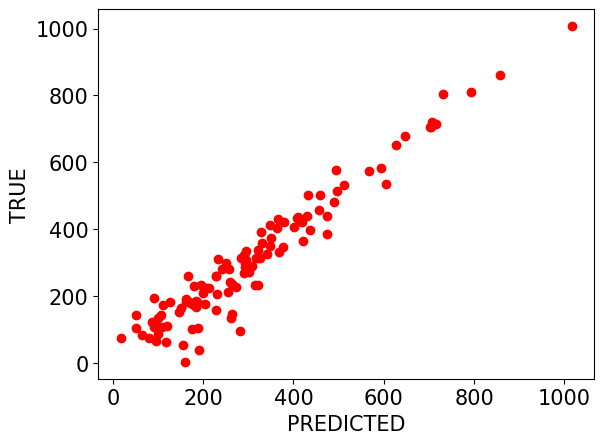

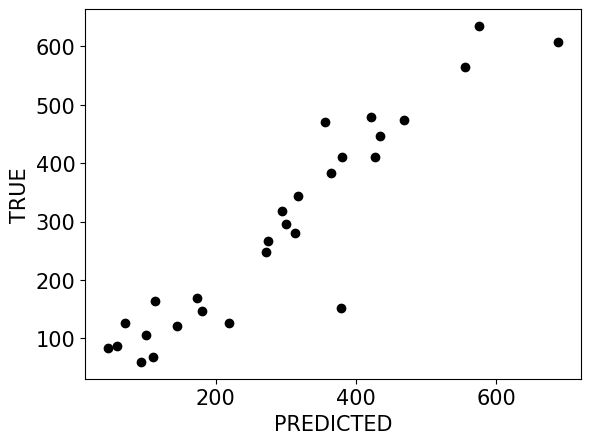

In [24]:
compstouse = min(rmsemin_comps, r2max_comps)
perc_split = 0.2
models.pls_model (0.2, PBE_moldescriptors_featues, PBE_Y, False, compstouse)

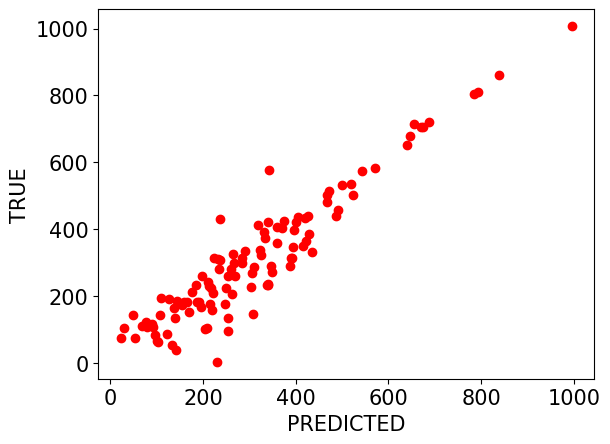

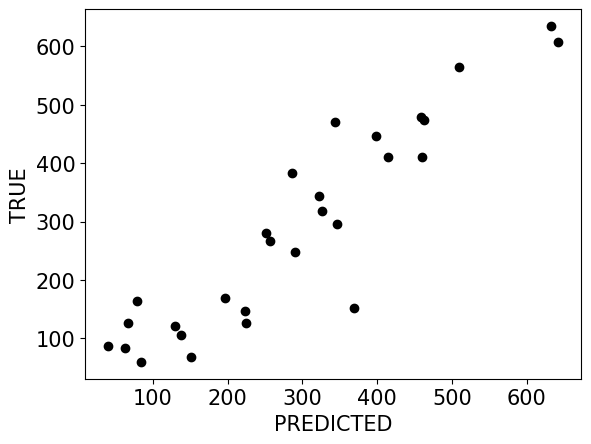

In [25]:
compstouse = 6
perc_split = 0.2
models.pls_model (0.2, PBE_moldescriptors_featues, PBE_Y, False, compstouse)

Using only HF instead

In [26]:
HF_moldescriptors_featues = []
HF_Y = []
HF_features_names = []

for idx, molname in enumerate(molnames):
    val = []
    for k,v in moldescriptors[idx].items():
        if k.startswith("HF_"):
            if idx == 0:
                HF_features_names.append(k)
            val.append(v)
    HF_moldescriptors_featues.append(val)
    HF_Y.append(labels[idx])

HF_Y = np.array(Y)
HF_moldescriptors_featues = np.array(HF_moldescriptors_featues)
print(HF_features_names)
df = pd.DataFrame(HF_moldescriptors_featues, columns=HF_features_names)

top_corr = get_top_correlations_blog(df, 0.8)
for tc in top_corr:
    print(tc)

['HF_Total_Charge', 'HF_Multiplicity', 'HF_Number_of_Electrons', 'HF_Nuclear_Repulsion', 'HF_One_Electron_Energy', 'HF_Two_Electron_Energy', 'HF_Potential_Energy', 'HF_Kinetic_Energy', 'HF_Dispersion_correction']
['HF_Kinetic_Energy', 'HF_Potential_Energy', -0.9999996985340858]
['HF_Two_Electron_Energy', 'HF_One_Electron_Energy', -0.9968337462456095]
['HF_One_Electron_Energy', 'HF_Kinetic_Energy', -0.9896606287885528]
['HF_One_Electron_Energy', 'HF_Potential_Energy', 0.9896574097445695]
['HF_Two_Electron_Energy', 'HF_Kinetic_Energy', 0.9752048268995052]
['HF_Potential_Energy', 'HF_Two_Electron_Energy', -0.9751945322192953]
['HF_Two_Electron_Energy', 'HF_Number_of_Electrons', 0.9487164202933104]
['HF_Nuclear_Repulsion', 'HF_Number_of_Electrons', 0.9424914868049947]
['HF_Number_of_Electrons', 'HF_One_Electron_Energy', -0.9295472924556163]
['HF_Nuclear_Repulsion', 'HF_Two_Electron_Energy', 0.8932293894247797]
['HF_Kinetic_Energy', 'HF_Number_of_Electrons', 0.8793009239627484]
['HF_Potenti

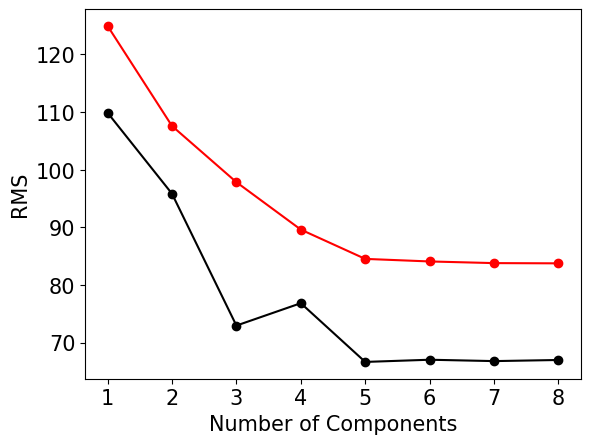

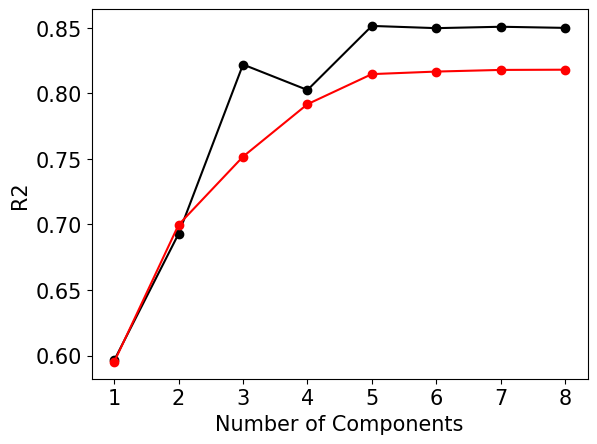

Max R2 Test set:  0.8514644916073468  N. Comps:  5
Min RMSE Test set:  66.6462461076138  N. Comps:  5


In [28]:
perc_split = 0.2
ncomps, rmses_test, rmses_train, r2s_test, r2s_train = \
    models.pls_model (0.2, HF_moldescriptors_featues , HF_Y, ncomp_max = 9)

r2max_comps = np.argmax(r2s_test)+1
rmsemin_comps = np.argmin(rmses_test)+1
print("Max R2 Test set: ", np.max(r2s_test), " N. Comps: ", r2max_comps)
print("Min RMSE Test set: ", np.min(rmses_test), " N. Comps: ", rmsemin_comps)

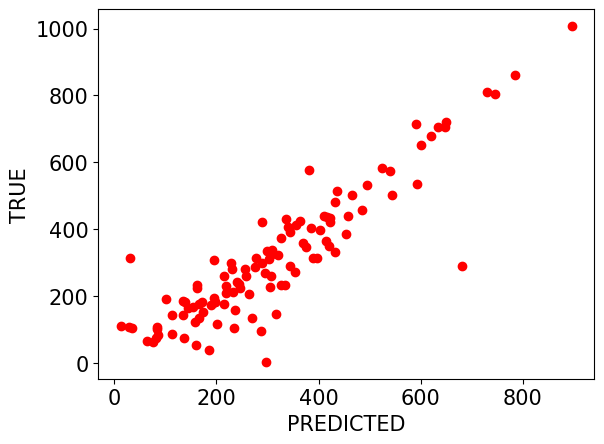

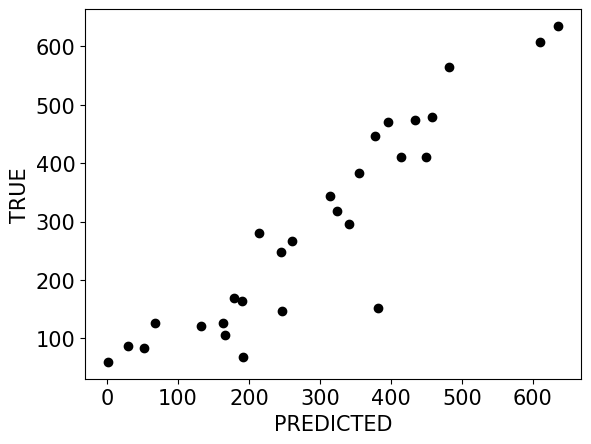

In [29]:
compstouse = 5
perc_split = 0.2
models.pls_model (0.2, HF_moldescriptors_featues, HF_Y, False, compstouse)

In [ ]:
%reload_ext models
#perc_split = 0.2
#min_train_rmse_hyper, min_test_rmse_hyper, max_train_r2_hyper, max_test_r2_hyper = \
#    models.rf_model (0.2, moldescriptors_featues, Y)

In [ ]:
%reload_ext models
#for d in [min_train_rmse_hyper, min_test_rmse_hyper, max_train_r2_hyper, max_test_r2_hyper]:
#    perc_split = 0.2
#    models.rf_model (0.2, moldescriptors_featues, Y, False, [d['n_estimators']], \
#                     [d['max_depth']], [d['min_samples_split']], \
#                         [d['min_samples_leaf']], [d['random_state']], \
#                             [d['bootstrap']], [d['max_features']])
